# RVAA - RealVsAiArt-based model
This notebook contains the code of our attempts at training a model on the RVAA dataset. 

The RVAA dataset contains around 2k images, which can either be real or AI-generated. However, unlike CIFAKE, the images are completely heterogenous: they have different resolution, different aspect-ratios and even different RGB formats. In addition, some of the images tagged as AI-generated are only "partially" so: in some cases, an image from a diffusion model will be shown side-by-side with a real image, or text will be present all over the image.

This can pose quite the challenge for our model. Nevertheless, the final results are quite promising.

In [1]:
import torch
from torchvision.models import resnet50
import model_utils
import plotter
import data_utils
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
import importlib
import pandas as pd
import torchvision.transforms as transforms
import xai

seed=42
model_utils.fix_random(seed)

TRAINING_MODE=True
plotter.set_display_mode(True)

import warnings
warnings.filterwarnings("ignore", category=UserWarning) # fixes PIL warning

c:\Users\tekke\Desktop\gauntlet\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt")
df_stats = data_utils.get_dataset_stats(dataset)
pd.DataFrame.from_dict(df_stats, orient='index')

# size of image to resize
IMG_SIZE = 224
DATASET_NAME = 'RVAA'

In [3]:
transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize(IMG_SIZE),                  # Resize the shorter side to IMG_SIZE while keeping aspect ratio
    transforms.Lambda(data_utils.pad_to_square),  # Apply the dynamic padding to make the image square
    transforms.Resize((IMG_SIZE, IMG_SIZE)),      # Ensure the final image is exactly IMG_SIZExIMG_SIZE
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing "should" help with Pretrained nets
])

dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform)

LEARNING_RATE = 3e-4
EPOCHS = 20
BATCH_SIZE = 32

# WARNING: IF YOU REBUILD THE DATALOADER, THE RESULT WILL DIFFER. RESTART THE KERNEL AND TRAIN AGAIN TO HAVE THE SAME RESULTS.
train_dataset, val_dataset, test_dataset = data_utils.train_test_split((0.7, 0.15), dataset=dataset, isRandom=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

loss_fn = nn.BCEWithLogitsLoss()
device = model_utils.get_device()
print(f"using {device} device")

dataloaders = (train_dataloader, val_dataloader)

using cuda device


## Baseline CNN training

In [4]:
importlib.reload(model_utils)
baseline_model = model_utils.CNN()
baseline_model.to(device)
model_name = "RVAA_BaseCNN"
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=LEARNING_RATE)

In [5]:
importlib.reload(model_utils)
artifacts = model_utils.train(dataloaders, loss_fn, optimizer,
                              baseline_model, model_name, BATCH_SIZE,
                              EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 56.6%, Avg loss: 0.754098
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 60.7%, Avg loss: 0.641704
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 58.6%, Avg loss: 0.867344


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 66.2%, Avg loss: 0.702516


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 61.4%, Avg loss: 0.757279


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 62.8%, Avg loss: 0.797080


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 62.8%, Avg loss: 0.881580


Epoch 8/20
-------------------------------
Validation Error:
Accuracy: 64.8%, Avg loss: 0.918233


Epoch 9/20
-------------------------------
Validation Error:
Accuracy: 58.6%, Avg loss: 0.

Test Error:
Accuracy: 76.7%, Avg loss: 0.567444
Confusion matrix report, tp: 45, fp: 17, fn: 17, tn:67
True


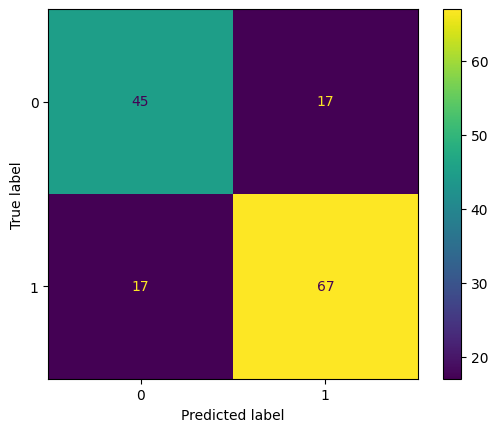

Precision: 0.73, Recall: 0.73, F1-Score: 0.73


(0.5674443006515503, tensor(0.7671, device='cuda:0'))

In [6]:
model_utils.test(test_dataloader, baseline_model, loss_fn, device,
                 model_name=model_name)

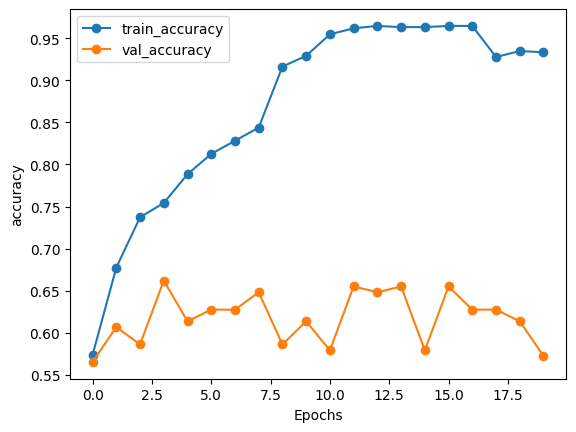

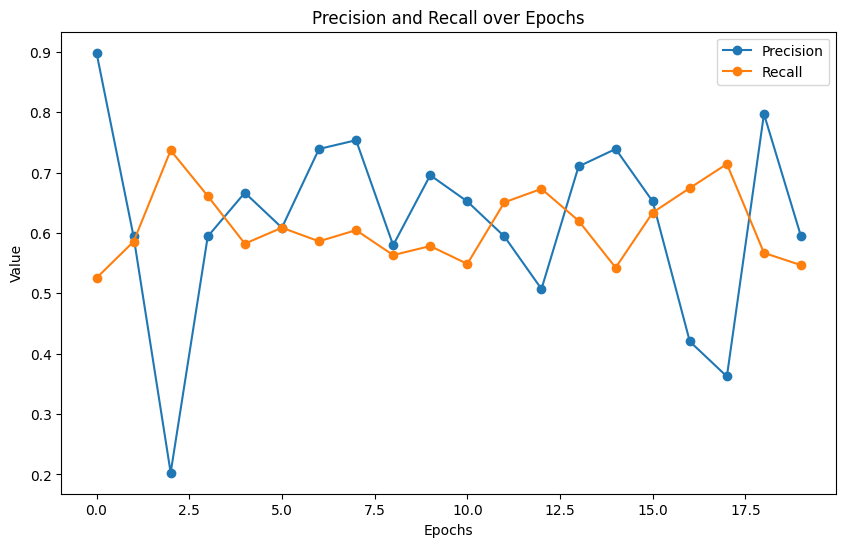

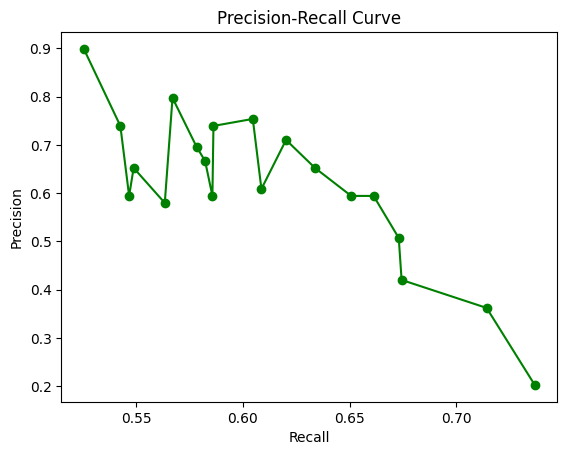

In [7]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

### Finetuned ResNet50

In [8]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=2)
ft_resnet50.to(device)

optimizer = torch.optim.Adam(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50"

In [9]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer,
                              ft_resnet50, model_name, BATCH_SIZE,
                              EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 59.3%, Avg loss: 0.675479
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 70.3%, Avg loss: 0.631803
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 70.3%, Avg loss: 0.609888
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 76.6%, Avg loss: 0.592564
New best model found! (based on lowest loss)
...and saved.


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 77.2%, Avg loss: 0.578013
New best model found! (based on lowest loss)
...and saved.


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 75.2%, Avg loss: 0.565485
New best model found! (based on lowest loss)
...and saved.


Epoch 7/20
-------------------------------
Validatio

Test Error:
Accuracy: 78.8%, Avg loss: 0.486834
Confusion matrix report, tp: 47, fp: 15, fn: 16, tn:68
True


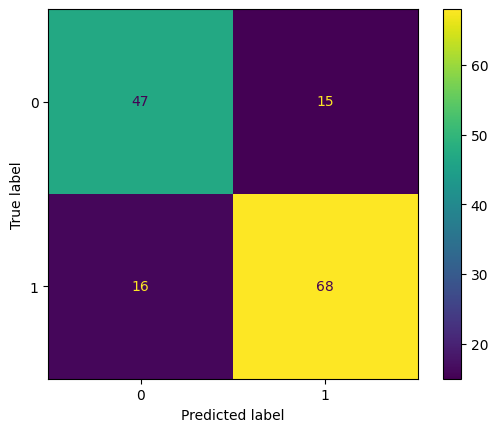

Precision: 0.76, Recall: 0.75, F1-Score: 0.75


(0.48683398962020874, tensor(0.7877, device='cuda:0'))

In [10]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name)

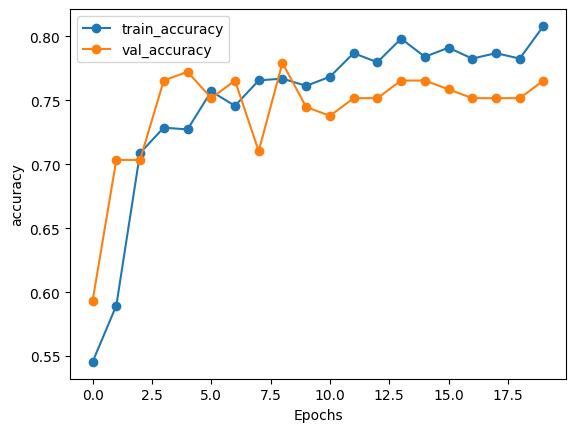

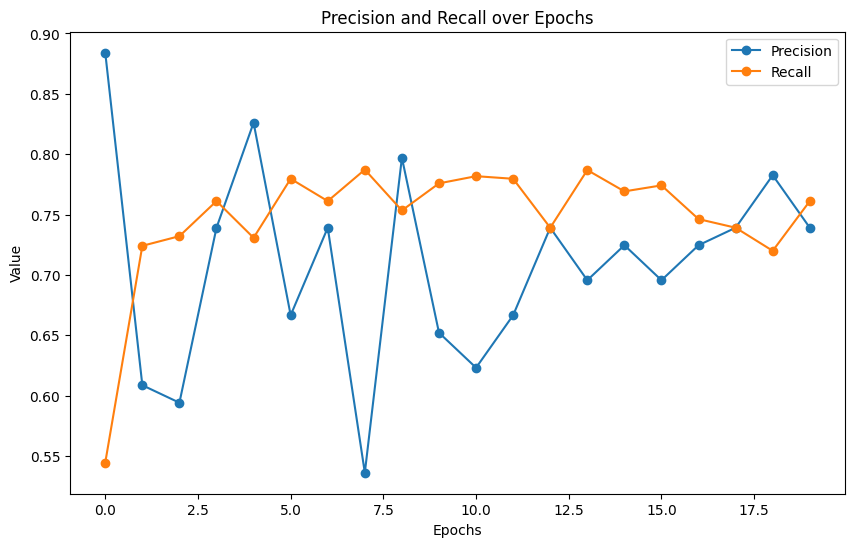

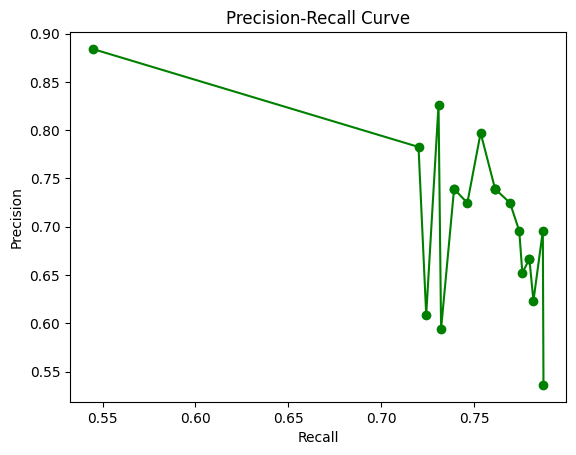

In [11]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

Step2 FT

In [12]:
for param in ft_resnet50.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(ft_resnet50.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50_beefy"

In [13]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Validation Error:
Accuracy: 54.5%, Avg loss: 4.624712
New best model found! (based on lowest loss)


Epoch 2/20
-------------------------------
Validation Error:
Accuracy: 64.8%, Avg loss: 1.786794
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Validation Error:
Accuracy: 69.0%, Avg loss: 1.058747
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Validation Error:
Accuracy: 75.9%, Avg loss: 0.691793
New best model found! (based on lowest loss)
...and saved.


Epoch 5/20
-------------------------------
Validation Error:
Accuracy: 73.8%, Avg loss: 0.700166


Epoch 6/20
-------------------------------
Validation Error:
Accuracy: 71.7%, Avg loss: 1.067725


Epoch 7/20
-------------------------------
Validation Error:
Accuracy: 60.7%, Avg loss: 1.615423


Epoch 8/20
-------------------------------
Validation Error:
Accuracy: 71.0%, Avg los

Test Error:
Accuracy: 81.5%, Avg loss: 0.633591
Confusion matrix report, tp: 54, fp: 8, fn: 19, tn:65
True


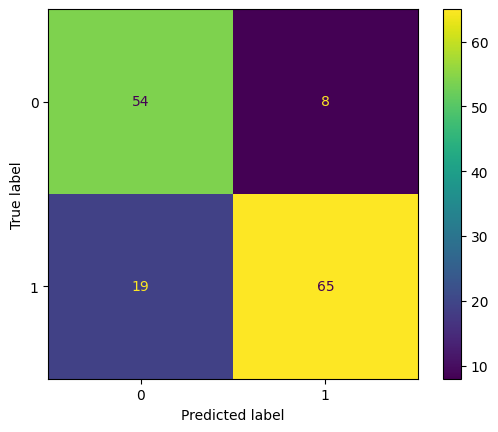

Precision: 0.87, Recall: 0.74, F1-Score: 0.80


(0.6335905432701111, tensor(0.8151, device='cuda:0'))

In [14]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device, model_name=model_name)

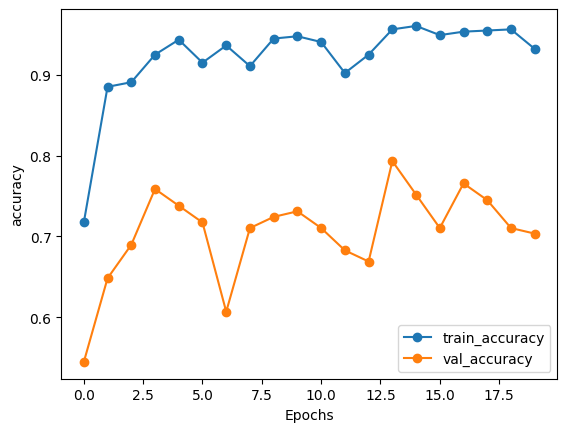

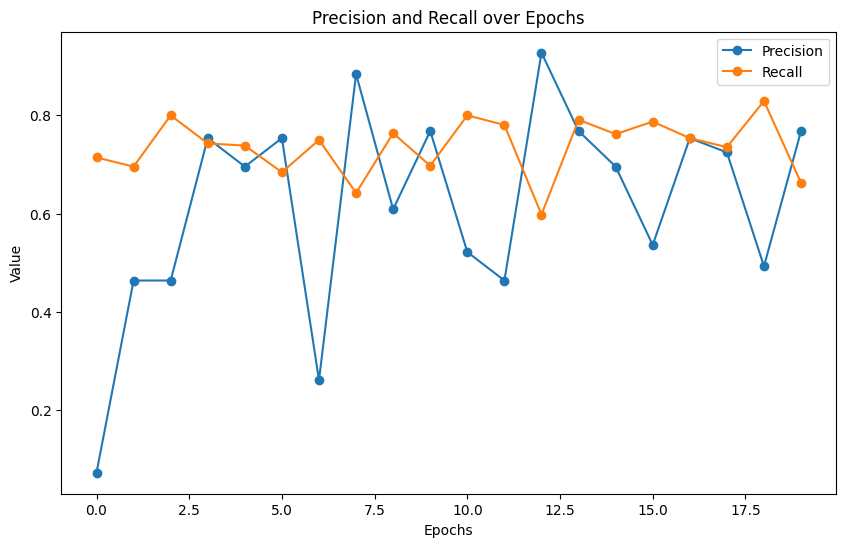

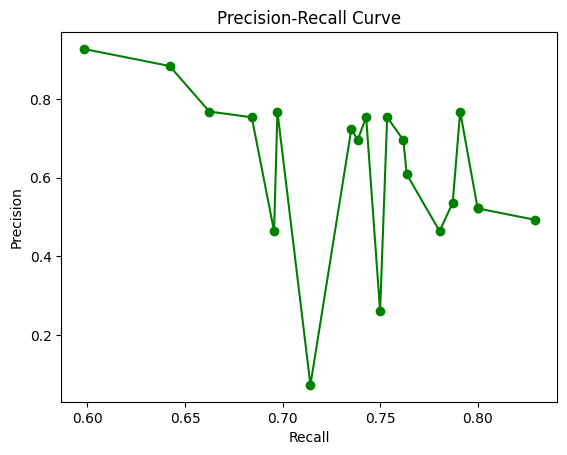

In [15]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts 
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

GradCAM Test

100%|██████████| 64/64 [00:09<00:00,  6.81it/s]


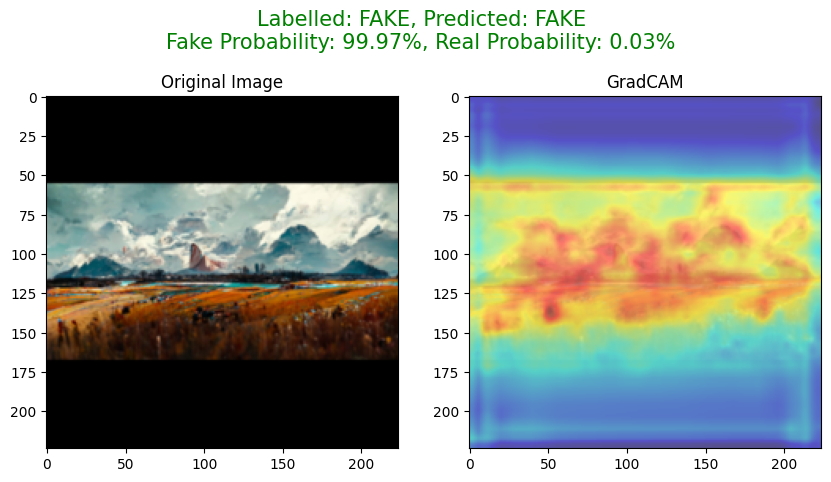

In [16]:
importlib.reload(xai)

xai.set_device(device)
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50, [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4],
                                model_name = model_name, dataset_name = DATASET_NAME,
                                index = 16)

100%|██████████| 64/64 [00:03<00:00, 17.10it/s]


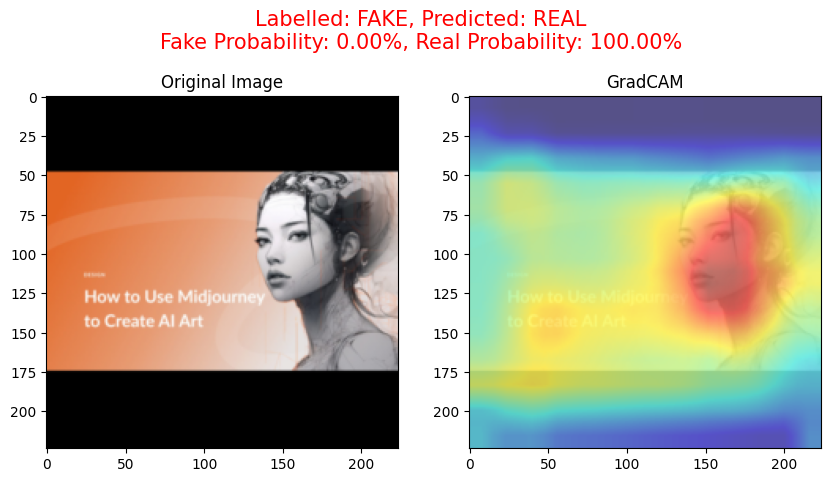

In [17]:
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50, [ft_resnet50.layer3, ft_resnet50.layer4],
                                model_name = model_name, dataset_name = DATASET_NAME,
                                index = 2)

100%|██████████| 128/128 [00:10<00:00, 12.63it/s]


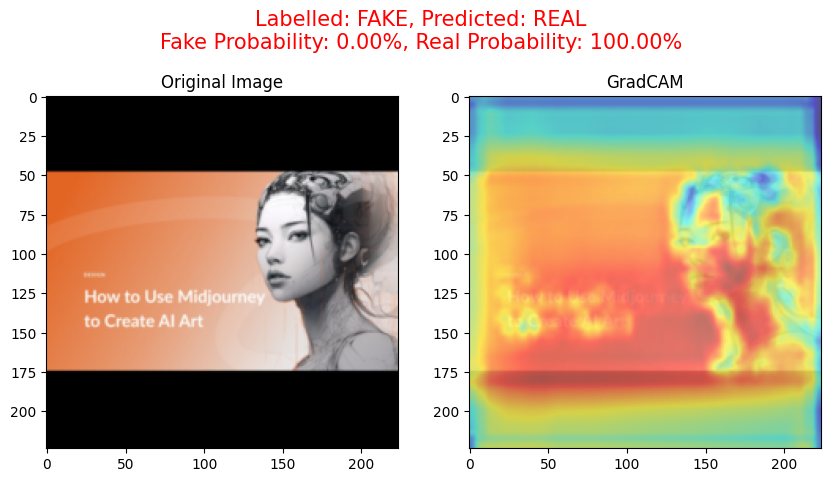

In [18]:
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50, [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4],
                                model_name = model_name, dataset_name = DATASET_NAME,
                                index = 2,
                                mapper="sc")

100%|██████████| 128/128 [00:03<00:00, 33.64it/s]


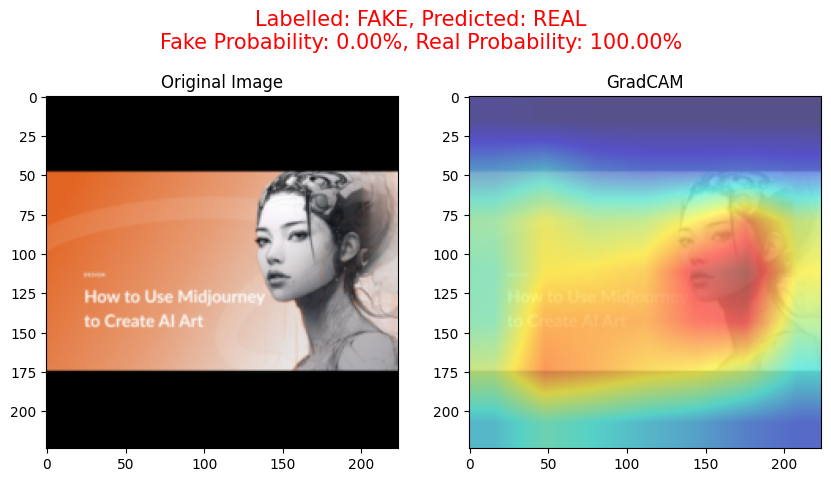

In [19]:
xai.explain_gradcam_single_image(test_dataloader,
                                ft_resnet50,
                                ft_resnet50.layer4,
                                model_name = model_name, dataset_name = DATASET_NAME,
                                index = 2,
                                mapper="sc")

LIME experiment

100%|██████████| 1000/1000 [00:04<00:00, 212.22it/s]


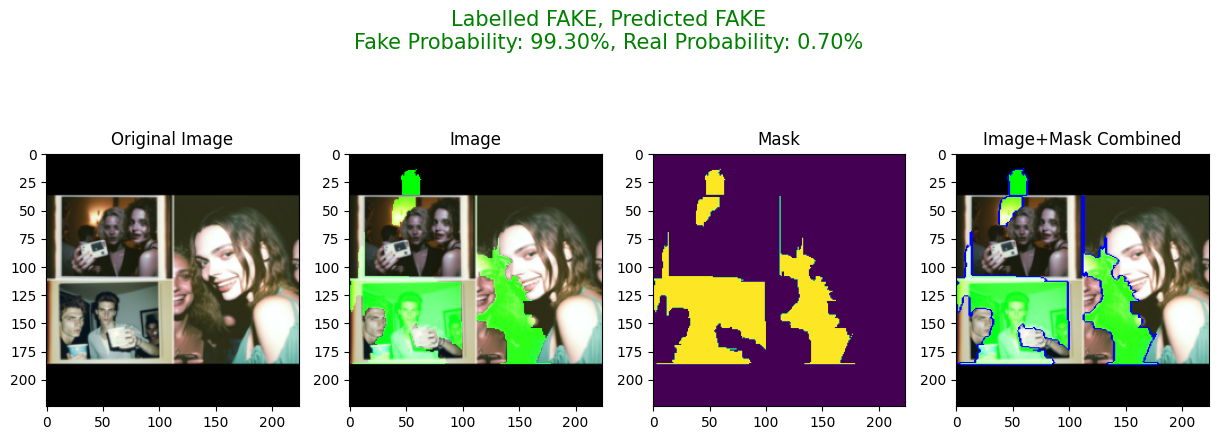

In [20]:
importlib.reload(xai)

xai.explain_lime_single_image(test_dataloader, ft_resnet50,
                              model_name = model_name, dataset_name = DATASET_NAME,
                              index = 3)

### GradCam batch visualization

In [21]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=2)
ft_resnet50.to(device)
ft_resnet50.load_state_dict(torch.load("checkpoints/best_RVAA_FTRes50_beefy.pth"))
model_name = "FTRes50_beefy"

C:\Users\tekke\AppData\Local\Temp\ipykernel_22188\3033350679.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft_resnet50.load_state_dict(torch.load("checkpoints/best_RVA

In [22]:
xai.explain_gradcam_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50, [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4], model_name, DATASET_NAME)

100%|██████████| 64/64 [00:05<00:00, 12.30it/s]


Visualized batch #1!


### Lime batch visualization

In [23]:
xai.explain_lime_batch(test_dataloader, test_dataloader.batch_size, ft_resnet50,
                        model_name=model_name, dataset_name=DATASET_NAME,
                        )

100%|██████████| 1000/1000 [00:03<00:00, 251.38it/s]


Visualized batch #1!


### Data Augmentation Experiment

In [ ]:
augmented_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')), # Convert to RGB
    transforms.Resize(IMG_SIZE),                 # Resize to IMG_SIZE while keeping aspect ratio
    transforms.Lambda(data_utils.pad_to_square), # Apply the dynamic padding to make the image square
    transforms.Resize((IMG_SIZE, IMG_SIZE)),     # Ensure the final image is IMG_SIZExIMG_SIZE
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.RandomRotation(90),  # Randomly rotate the image by up to 90 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing "should" help with Pretrained nets
])


In [84]:
from torch.utils.data import DataLoader, Subset, ConcatDataset
import numpy as np
from torchvision import transforms

original_dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform)

# we are doing the same thing as the train_test_split function
train_size = int(0.7 * len(original_dataset))
val_size = int(0.15 * len(original_dataset))
test_size = len(original_dataset) - train_size - val_size

generator = torch.Generator()
generator.manual_seed(seed)
train_indices, val_indices, test_indices = torch.utils.data.random_split(
    range(len(original_dataset)),
    [train_size, val_size, test_size],
    generator=generator
)

train_dataset = Subset(original_dataset, train_indices)
val_dataset = Subset(original_dataset, val_indices)
test_dataset = Subset(original_dataset, test_indices)

augmented_size = int(1.0 * len(train_dataset))
augmented_indices = np.random.choice(len(train_dataset), augmented_size, replace=False)

augmented_train_dataset = Subset(data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=augmented_transform),
                                 [train_indices[i] for i in augmented_indices])

combined_train_dataset = ConcatDataset([train_dataset, augmented_train_dataset])

train_dataloader = DataLoader(combined_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

dataloaders = (train_dataloader, val_dataloader)


In [94]:
print(len(train_dataset), len(combined_train_dataset))

679 1358


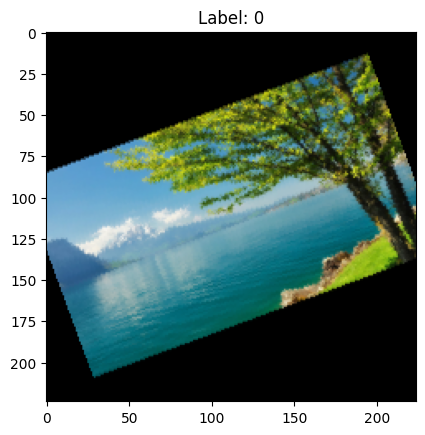

In [92]:
data_utils.show_random_sample(train_dataloader)

In [26]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=2)
ft_resnet50.to(device)

optimizer = torch.optim.AdamW(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50_experiment"


In [27]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Training loss: 0.619562, train accuracy: 59.30%  [ 1280/ 1358]
Validation Error:
Accuracy: 65.5%, Avg loss: 0.635919
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Training loss: 0.631953, train accuracy: 69.77%  [ 1280/ 1358]
Validation Error:
Accuracy: 62.1%, Avg loss: 0.606923
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Training loss: 0.552950, train accuracy: 72.27%  [ 1280/ 1358]
Validation Error:
Accuracy: 68.3%, Avg loss: 0.576344
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------
Training loss: 0.531382, train accuracy: 76.72%  [ 1280/ 1358]
Validation Error:
Accuracy: 72.4%, Avg loss: 0.559351
New best model found! (based on lowest loss)
...and saved.


Epoch 5/20
-------------------------------
Training loss: 0.514917, train accuracy: 75.47%  [ 1280/ 1358]
Validation

Test Error:
Accuracy: 80.8%, Avg loss: 0.464731
Confusion matrix report, tp: 45, fp: 17, fn: 11, tn:73
True


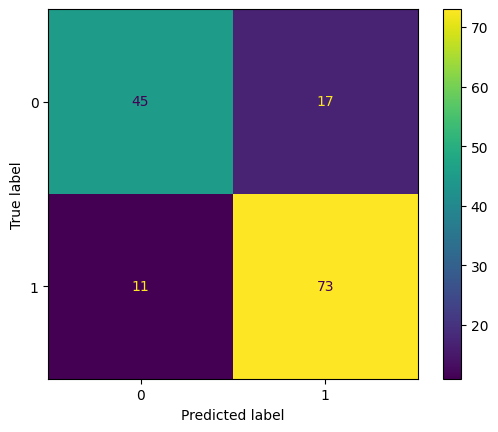

Precision: 0.73, Recall: 0.80, F1-Score: 0.76


(0.46473137736320497, tensor(0.8082, device='cuda:0'))

In [28]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name)

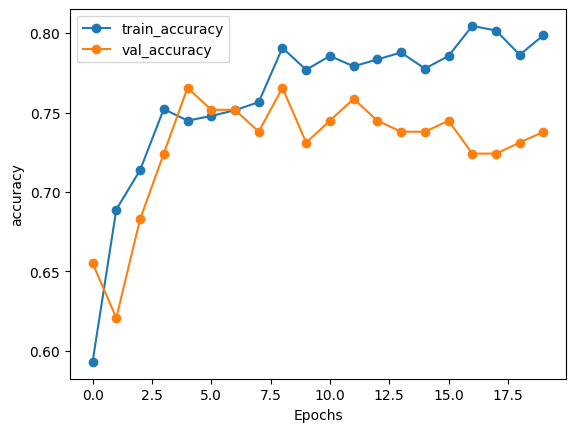

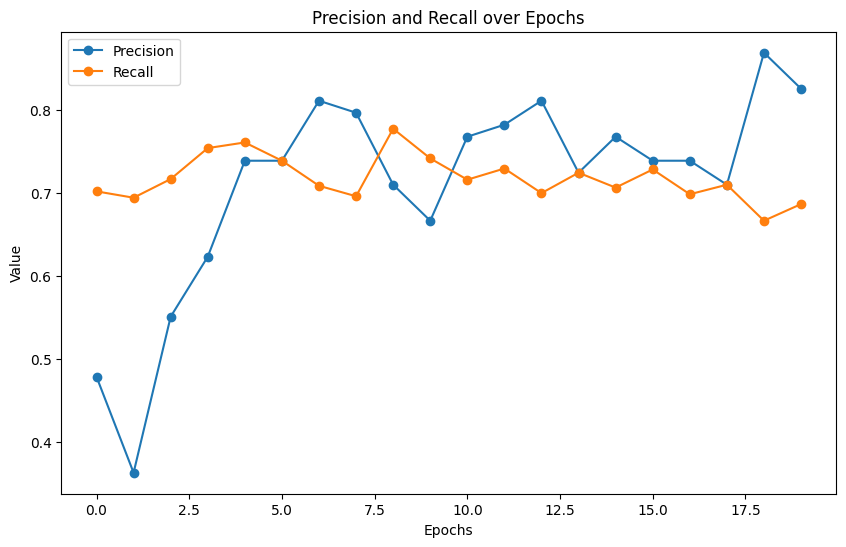

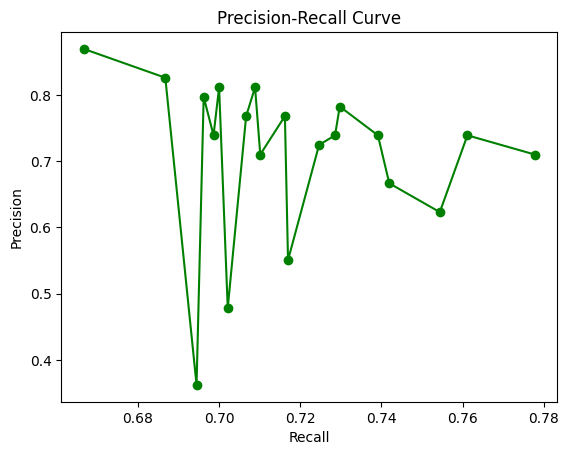

In [29]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

In [30]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resnet50.parameters(), lr=LEARNING_RATE)
model_name = "RVAA_FTRes50_experiment_beefy"

In [31]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/20
-------------------------------
Training loss: 0.391419, train accuracy: 74.38%  [ 1280/ 1358]
Validation Error:
Accuracy: 67.6%, Avg loss: 1.194164
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------
Training loss: 0.281455, train accuracy: 85.78%  [ 1280/ 1358]
Validation Error:
Accuracy: 75.2%, Avg loss: 0.722531
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------
Training loss: 0.448649, train accuracy: 88.05%  [ 1280/ 1358]
Validation Error:
Accuracy: 63.4%, Avg loss: 0.890289


Epoch 4/20
-------------------------------
Training loss: 0.212676, train accuracy: 87.73%  [ 1280/ 1358]
Validation Error:
Accuracy: 73.1%, Avg loss: 0.843092


Epoch 5/20
-------------------------------
Training loss: 0.179131, train accuracy: 90.62%  [ 1280/ 1358]
Validation Error:
Accuracy: 76.6%, Avg loss: 0.809130


Epoch 6/20
-------------------------------
Training loss: 0.290198, trai

Test Error:
Accuracy: 71.9%, Avg loss: 0.713071
Confusion matrix report, tp: 59, fp: 3, fn: 38, tn:46
True


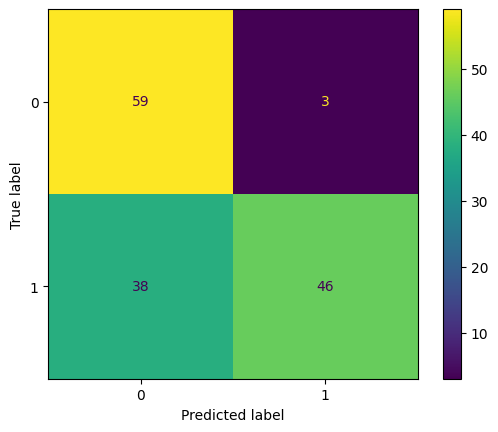

Precision: 0.95, Recall: 0.61, F1-Score: 0.74


(0.713070559501648, tensor(0.7192, device='cuda:0'))

In [32]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name)

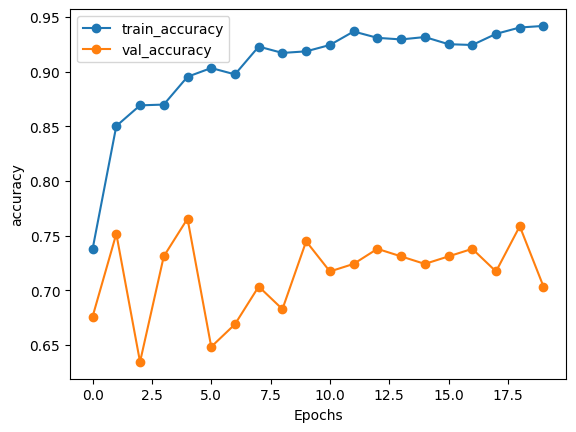

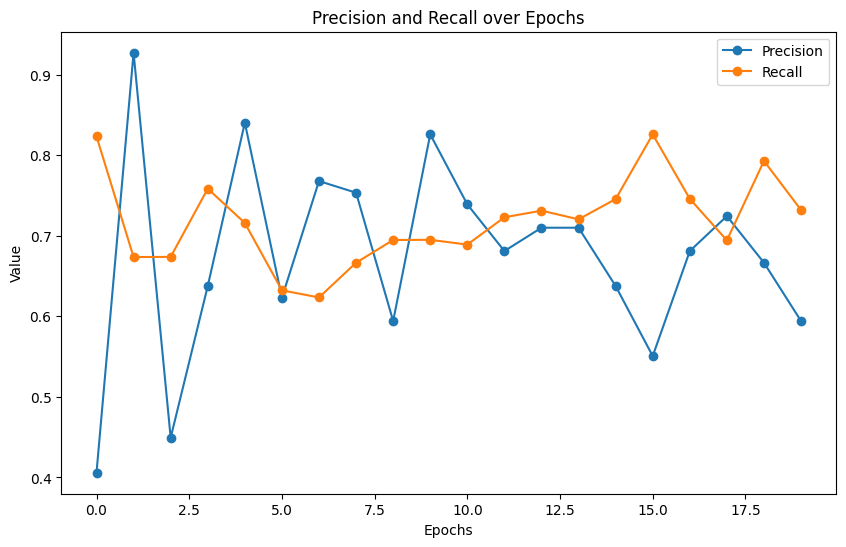

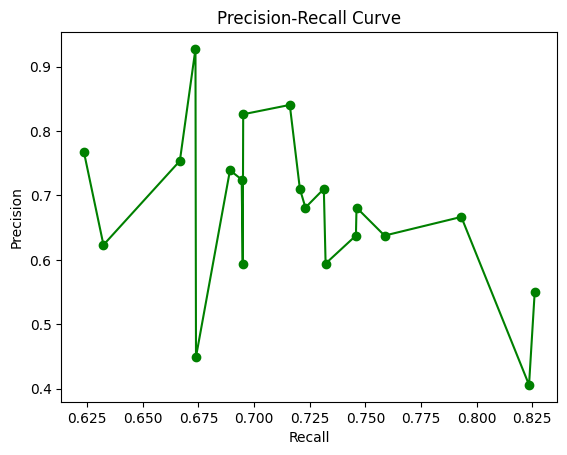

In [33]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)